# Exploratory Analysis of US Options Data


## Helper Functions

In [1]:
import requests
import os
from typing import Optional
import pandas as pd
import glob
import os

os.chdir("/Users/andrewfish/Developer/Financial Data")

def download_b2_file(file_path: str):
    endpoint = f"http://localhost:8000/backblaze/download"
    expected_path = os.path.join("data", "downloads", os.path.basename(file_path))
    try:
        response = requests.post(endpoint, params={"file_path": file_path})
        response.raise_for_status()  # Raise exception for non-200 status codes
        return expected_path
    
    except requests.exceptions.RequestException as e:
        return None
    
def load_options_files(file_paths: list):
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file, compression='gzip')
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    print(f"\nFinal DataFrame shape: {combined_df.shape}")
    return combined_df

## Download Data
#### October 2024


In [ ]:
import datetime

# Generate list of dates for October 2024
start_date = datetime.date(2024, 10, 1)
end_date = datetime.date(2024, 10, 31)
delta = datetime.timedelta(days=1)

downloaded_files = []
failed_files = []

current_date = start_date
while current_date <= end_date:
    # Format the file path according to the B2 structure
    file_path = f"us_options_opra/trades_v1/2024/10/{current_date.strftime('%Y-%m-%d')}.csv.gz"
    result = download_b2_file(file_path)
    
    if result:
        downloaded_files.append(result)
    else:
        failed_files.append(file_path)
    
    current_date += delta

print(f"\nDownload Summary:")
print(f"Successfully downloaded: {len(downloaded_files)} files")
print(f"Failed downloads: {len(failed_files)}")

### Load Data into DataFrame

In [28]:
options_df = load_options_files(downloaded_files)

# Display first few rows and basic info
print("\nFirst few rows:")
display(options_df.head())
print("\nDataFrame Info:")
display(options_df.info())


Final DataFrame shape: (143517818, 7)

First few rows:


,ticker,conditions,correction,exchange,price,sip_timestamp,size
0,O:A241018C00140000,232.0,0,308,7.78,1727789703392000000,1
1,O:A241018C00140000,232.0,0,323,7.13,1727789729177000000,1
2,O:A241018C00140000,233.0,0,302,6.35,1727791874701000000,1
3,O:A241018C00145000,232.0,0,308,4.52,1727789406941000000,2
4,O:A241018C00145000,209.0,0,325,3.55,1727790534394000000,2



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143517818 entries, 0 to 143517817
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ticker         object 
 1   conditions     float64
 2   correction     int64  
 3   exchange       int64  
 4   price          float64
 5   sip_timestamp  int64  
 6   size           int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 7.5+ GB


None

In [ ]:
# 1) Convert sip_timestamp to datetime
import pandas as pd

options_df['event_datetime'] = pd.to_datetime(options_df['sip_timestamp'], unit='ns')
print("\nConverted 'sip_timestamp' to 'event_datetime' using nanosecond resolution.")
print(options_df[['sip_timestamp','event_datetime']].head(3))

In [30]:
# 2) Quick Ticker Volume Ranking
# Because the data can be huge, consider sampling if memory is limited, e.g.:
# sample_df = options_df.sample(n=1_000_000, random_state=42)
# However, for demonstration, we'll do the full dataset while mindful of resource usage.

ticker_volume = options_df.groupby('ticker')['size'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 tickers by total traded size (volume) in October 2024:")
print(ticker_volume)


Top 10 tickers by total traded size (volume) in October 2024:
ticker
O:NVDA241018C00140000    1893887
O:NVDA241011C00135000    1269897
O:NVDA241025C00140000    1200430
O:NVDA241025C00142000    1078566
O:NVDA241018C00138000    1024862
O:NVDA241025C00145000     977190
O:NVDA241018C00135000     904857
O:FXI241115C00045000      904627
O:NVDA241004C00125000     853878
O:FXI250321C00044000      821577
Name: size, dtype: int64


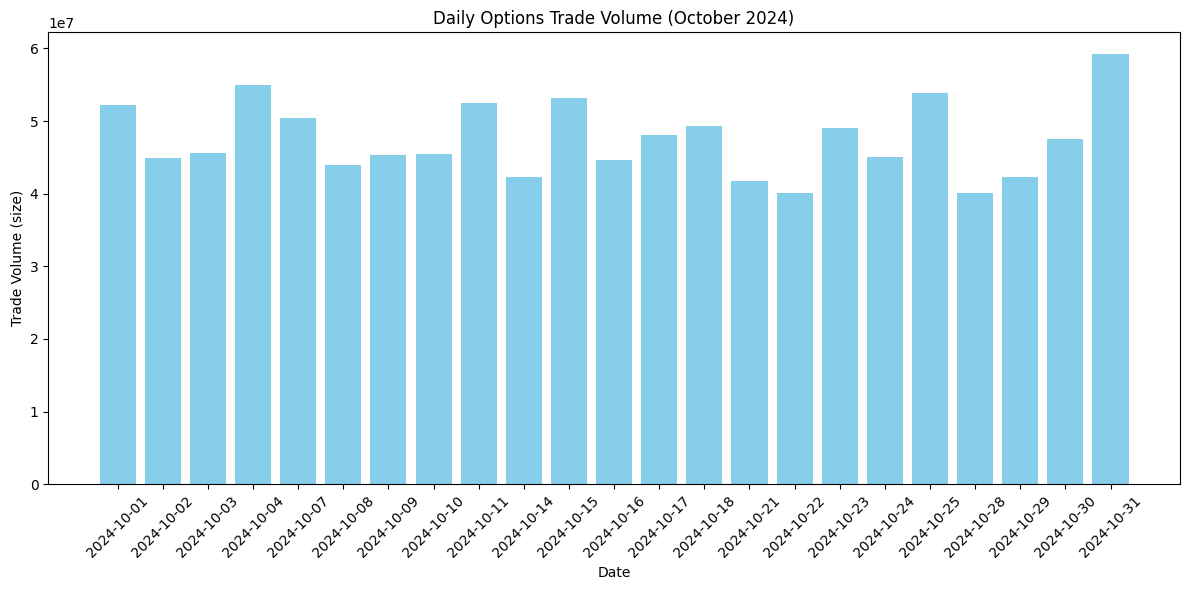

In [31]:
# 3) Simple Daily Volume Plot
# This groups by the actual date (year-month-day) from our 'event_datetime' column
# then sums the 'size' (representing trade volume) per day.

import matplotlib.pyplot as plt

# Group by date
options_df['date'] = options_df['event_datetime'].dt.date
daily_volume = options_df.groupby('date')['size'].sum().reset_index()

# Plot daily volume
plt.figure(figsize=(12,6))
plt.bar(daily_volume['date'].astype(str), daily_volume['size'], color='skyblue')
plt.title("Daily Options Trade Volume (October 2024)")
plt.xlabel("Date")
plt.ylabel("Trade Volume (size)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
# ------------------------------------------------------------------
# 1) Data Quality Checks
# ------------------------------------------------------------------
# Quick validations:
#    1) Non-null columns for 'ticker', 'price', 'size', 'sip_timestamp'
#    2) Reasonable price, e.g., price > 0
#    3) Basic descriptive stats
# Feel free to add more rules as needed.

import numpy as np

required_cols = ['ticker', 'price', 'size', 'sip_timestamp']
missing_cols = [col for col in required_cols if col not in options_df.columns]

if missing_cols:
    print(f"Error: Missing required columns: {missing_cols}")
else:
    # 1) Check for any row with null in the required columns
    null_counts = options_df[required_cols].isnull().sum()
    print("\nNull counts in required columns:")
    print(null_counts)

    # 2) Ensure price is positive (some options trades can show up at $0, but let's be naive to start)
    invalid_prices = options_df[options_df['price'] <= 0]
    if len(invalid_prices) > 0:
        print(f"\nDetected {len(invalid_prices)} rows with price <= 0. Investigate these:")
        display(invalid_prices.head())
    else:
        print("\nNo invalid (<= 0) prices found.")

    # 3) Descriptive statistics on size and price
    print("\nDescriptive stats for 'price' and 'size':")
    display(options_df[['price', 'size']].describe())


Null counts in required columns:
ticker           0
price            0
size             0
sip_timestamp    0
dtype: int64

No invalid (<= 0) prices found.

Descriptive stats for 'price' and 'size':


,price,size
count,1.435178e+08,1.435178e+08
mean,5.043013e+00,7.607102e+00
std,2.708790e+01,1.573249e+02
min,1.000000e-02,1.000000e+00
25%,5.000000e-01,1.000000e+00
50%,1.450000e+00,1.000000e+00
75%,3.860000e+00,5.000000e+00
max,1.633889e+04,4.000000e+05


In [33]:
# ------------------------------------------------------------------
# 2) Detecting Unusual Volume by Ticker-Day (Simple Approach)
# ------------------------------------------------------------------
# Steps:
#    1) Convert timestamp to date if not already -> 'event_datetime' => 'date'
#    2) Compute daily volume for each ticker
#    3) Compute mean & std of daily volume (per ticker) across the entire dataset
#    4) Flag any day that is above a threshold (e.g., mean + 3*std) as "unusual volume"

import pandas as pd
from datetime import datetime

# If you haven't already, convert to datetime & create "date" column
if 'event_datetime' not in options_df.columns:
    options_df['event_datetime'] = pd.to_datetime(options_df['sip_timestamp'], unit='ns')

options_df['date'] = options_df['event_datetime'].dt.date

# 1) Group by ticker and date, summing 'size' for total daily volume
ticker_daily_volume = options_df.groupby(['ticker', 'date'], as_index=False)['size'].sum()
ticker_daily_volume.rename(columns={'size': 'daily_volume'}, inplace=True)

# 2) For each ticker, compute mean & std of daily volume across all days
stats_per_ticker = ticker_daily_volume.groupby('ticker')['daily_volume'].agg(['mean', 'std']).reset_index()
stats_per_ticker.rename(columns={'mean': 'avg_volume', 'std': 'std_volume'}, inplace=True)

# 3) Merge these stats back onto the daily volume DataFrame
merged_df = ticker_daily_volume.merge(stats_per_ticker, on='ticker', how='left')

# Define your threshold for "unusual" volume; e.g., > avg + 3*std
threshold_mult = 3
merged_df['unusual_volume'] = merged_df['daily_volume'] > (merged_df['avg_volume'] + threshold_mult * merged_df['std_volume'])

# Display only the unusual events
unusual_events = merged_df[merged_df['unusual_volume']]

print(f"\nUnusual Volume Events (Mean + {threshold_mult}*Std): {len(unusual_events)} total detections")
display(unusual_events.sort_values('daily_volume', ascending=False).head(20))


Unusual Volume Events (Mean + 3*Std): 72455 total detections


,ticker,date,daily_volume,avg_volume,std_volume,unusual_volume
1601848,O:FXI250321C00044000,2024-10-07,801421,37344.409091,170667.293973,True
1601887,O:FXI250321C00047000,2024-10-07,800253,61604.692308,221936.205692,True
4095315,O:SPY241028P00581000,2024-10-28,521851,53263.000000,156123.195956,True
1597775,O:FXI241115C00040000,2024-10-02,482591,32753.565217,100631.596801,True
4084023,O:SPY241018C00585000,2024-10-18,452380,53435.785714,120770.370807,True
1597881,O:FXI241115C00045000,2024-10-02,429563,41119.409091,110772.275209,True
4086530,O:SPY241018P00583000,2024-10-18,399801,38459.642857,106733.931674,True
4086542,O:SPY241018P00584000,2024-10-18,396414,41014.000000,113317.249419,True
4102292,O:SPY241031P00570000,2024-10-31,384593,22599.565217,79040.625391,True
4441743,O:TSLA241025C00270000,2024-10-25,366846,26225.052632,85269.909122,True


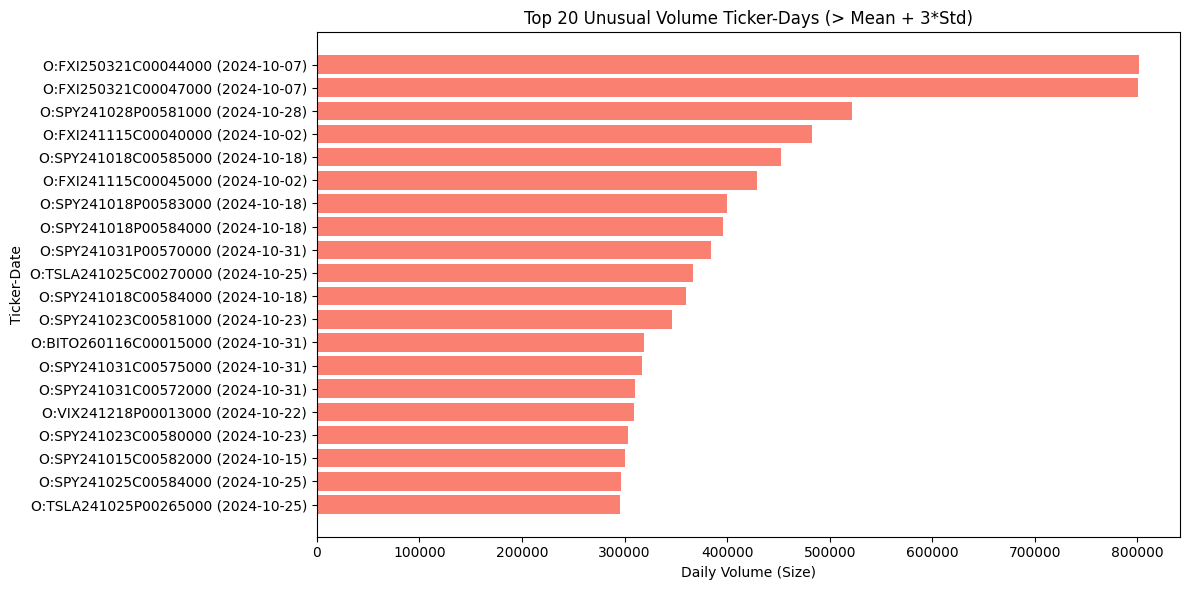

In [34]:
# ------------------------------------------------------------------
# 3) Visualizing Unusual Volume Ticker-Days (Optional Plot)
# ------------------------------------------------------------------
# This plots a bar chart of daily volume for just the unusual events.
# For a real system, you might save these to a database or investigate them more deeply.

import matplotlib.pyplot as plt

if not unusual_events.empty:
    # Sort to get the top 20 largest anomalies
    top_unusual = unusual_events.nlargest(20, 'daily_volume')

    plt.figure(figsize=(12, 6))
    plt.barh(
        top_unusual.apply(lambda row: f"{row['ticker']} ({row['date']})", axis=1),
        top_unusual['daily_volume'],
        color='salmon'
    )
    plt.title(f"Top 20 Unusual Volume Ticker-Days (> Mean + {threshold_mult}*Std)")
    plt.xlabel("Daily Volume (Size)")
    plt.ylabel("Ticker-Date")
    plt.gca().invert_yaxis()  # Flip so largest is at top
    plt.tight_layout()
    plt.show()
else:
    print("\nNo unusual volume events found using the current threshold.")

In [35]:
# ---------------------------------------------------------------
# Compute Daily OHLC, Volume, and Returns per (ticker, date)
# ---------------------------------------------------------------
import pandas as pd

# Assumes 'options_df' has columns: 'price', 'event_datetime', 'size', etc.
# and that you already have a 'date' column via:
# options_df['date'] = pd.to_datetime(options_df['sip_timestamp'], unit='ns').dt.date

# 1) For each ticker and date, compute:
#    - daily_open   = FIRST trade price
#    - daily_close  = LAST trade price
#    - daily_high   = MAX trade price
#    - daily_low    = MIN trade price
#    - daily_volume = SUM of 'size'
#    - daily_return = (close - open) / open

daily_stats = (
    options_df
    .groupby(['ticker', 'date'])
    .agg(
        daily_open=('price', 'first'),
        daily_close=('price', 'last'),
        daily_high=('price', 'max'),
        daily_low=('price', 'min'),
        daily_volume=('size', 'sum'),
        first_ts=('event_datetime', 'min'),
        last_ts=('event_datetime', 'max'),
    )
    .reset_index()
)

# 2) Compute daily return
daily_stats['daily_return'] = (
    (daily_stats['daily_close'] - daily_stats['daily_open']) 
    / daily_stats['daily_open']
)

print("Daily Stats (first few rows):")
display(daily_stats.head(5))

Daily Stats (first few rows):


,ticker,date,daily_open,daily_close,daily_high,daily_low,daily_volume,first_ts,last_ts,daily_return
0,O:A241018C00130000,2024-10-17,7.23,7.23,7.23,7.23,1,2024-10-17 19:05:56.285,2024-10-17 19:05:56.285,0.000000
1,O:A241018C00135000,2024-10-14,8.85,8.85,8.85,8.85,4,2024-10-14 13:54:15.006,2024-10-14 13:54:15.006,0.000000
2,O:A241018C00135000,2024-10-15,10.40,10.40,10.40,10.40,10,2024-10-15 13:46:15.010,2024-10-15 13:46:15.010,0.000000
3,O:A241018C00135000,2024-10-17,5.54,3.66,5.54,3.66,12,2024-10-17 14:01:59.263,2024-10-17 17:20:05.631,-0.339350
4,O:A241018C00140000,2024-10-01,7.78,6.35,7.78,6.35,3,2024-10-01 13:35:03.392,2024-10-01 14:11:14.701,-0.183805


In [36]:
# ---------------------------------------------------------------
# Flag Ticker-Days with "Significant Price Moves"
# ---------------------------------------------------------------
# We'll define "significant" as abs(daily_return) > (avg_return + threshold * std_return).
# You might also consider percentile thresholds (e.g., top 5% of returns).

threshold = 2  # e.g., 2 std dev above mean

# 1) Compute mean & std of daily_return per ticker
stats_per_ticker_price = daily_stats.groupby('ticker')['daily_return'].agg(['mean', 'std']).reset_index()
stats_per_ticker_price.rename(columns={'mean': 'avg_return', 'std': 'std_return'}, inplace=True)

# 2) Merge with daily_stats
price_moves_df = daily_stats.merge(stats_per_ticker_price, on='ticker', how='left')

# 3) Define significant move condition (you can refine this logic as you see fit)
price_moves_df['significant_move'] = (
    price_moves_df['daily_return'].abs() 
    > (price_moves_df['avg_return'].abs() + threshold * price_moves_df['std_return'])
)

significant_moves = price_moves_df[price_moves_df['significant_move']].copy()

print(f"Number of (ticker, date) entries flagged as 'significant': {len(significant_moves)}")
display(significant_moves.sort_values('daily_return', ascending=False).head(10))

Number of (ticker, date) entries flagged as 'significant': 236589


,ticker,date,daily_open,daily_close,daily_high,daily_low,daily_volume,first_ts,last_ts,daily_return,avg_return,std_return,significant_move
4712424,O:V241018C00275000,2024-10-10,0.01,4.15,4.40,0.01,114,2024-10-10 13:30:02.484,2024-10-10 19:53:13.243,414.0,29.718332,110.605090,True
4754700,O:VIXW241113C00015000,2024-10-21,0.01,3.30,3.30,0.01,12,2024-10-21 15:52:07.783,2024-10-21 16:03:40.401,329.0,41.205480,116.286606,True
3798453,O:SNOW241108C00125000,2024-10-04,0.01,3.05,3.40,0.01,32,2024-10-04 13:30:17.956,2024-10-04 17:29:06.191,304.0,13.772497,64.823500,True
3949684,O:SPXW241010P05725000,2024-10-04,0.10,29.07,53.50,0.10,575,2024-10-04 12:30:04.257,2024-10-04 20:09:57.615,289.7,35.996746,102.512798,True
2638652,O:MSTR241018P00186000,2024-10-14,0.01,2.66,2.92,0.01,213,2024-10-14 13:31:24.915,2024-10-14 19:59:34.819,265.0,18.800695,70.862122,True
2091962,O:JBLU270115C00007000,2024-10-01,0.01,2.25,2.25,0.01,4,2024-10-01 14:03:19.202,2024-10-01 15:37:26.836,224.0,20.328038,67.550367,True
418233,O:ATAT241115C00030000,2024-10-04,0.01,2.13,2.13,0.01,3,2024-10-04 13:44:11.753,2024-10-04 18:56:57.892,212.0,11.144964,48.640363,True
625714,O:BKNG241101P04320000,2024-10-31,0.01,2.06,2.06,0.01,7,2024-10-31 13:30:53.780,2024-10-31 13:55:41.449,205.0,20.514357,64.821675,True
1901226,O:HUM241101C00310000,2024-10-17,0.01,2.00,2.00,0.01,7,2024-10-17 13:34:23.401,2024-10-17 19:58:22.974,199.0,11.101967,46.895453,True
2638611,O:MSTR241018P00182500,2024-10-14,0.01,2.00,2.25,0.01,419,2024-10-14 13:31:02.768,2024-10-14 19:59:29.963,199.0,19.810676,62.963013,True


In [37]:
# ---------------------------------------------------------------
# Combine Price Move Flags with Volume Anomalies
# ---------------------------------------------------------------

# Suppose your unusual volume events were in a DataFrame called 'unusual_events'
# with columns: ['ticker', 'date', 'daily_volume', 'unusual_volume' == True, etc.]
# We'll merge it with our 'significant_moves' to see common days.

if 'unusual_events' in globals():
    combined_df = significant_moves.merge(
        unusual_events[['ticker', 'date', 'daily_volume', 'unusual_volume']],
        on=['ticker','date'],
        how='inner'
    )

    print(f"Number of (ticker, date) with BOTH significant price move AND unusual volume: {len(combined_df)}")
    display(combined_df.sort_values('daily_return', ascending=False).head(10))
    
    # Example: Quick look at correlation among the flagged sets
    overlap_ratio = len(combined_df) / len(significant_moves)
    print(f"\nOverlap ratio: {overlap_ratio:.2%} of days with significant price moves also had unusual volume.")
else:
    print("No 'unusual_events' DataFrame found. Run the volume anomaly detection code first.")

Number of (ticker, date) with BOTH significant price move AND unusual volume: 13366


,ticker,date,daily_open,daily_close,daily_high,daily_low,daily_volume_x,first_ts,last_ts,daily_return,avg_return,std_return,significant_move,daily_volume_y,unusual_volume
5117,O:KLAC241018P00720000,2024-10-15,0.20,22.60,28.30,0.20,262,2024-10-15 13:57:13.739,2024-10-15 19:51:27.111,112.000000,7.999041,29.936490,True,262,True
8509,O:RCL241101C00215000,2024-10-29,0.01,1.11,2.91,0.01,1032,2024-10-29 13:30:31.992,2024-10-29 19:59:50.375,110.000000,7.779331,29.423315,True,1032,True
2170,O:COIN241101P00182500,2024-10-31,0.05,5.25,5.50,0.05,3061,2024-10-31 13:30:29.156,2024-10-31 19:59:16.806,104.000000,7.338195,27.822037,True,3061,True
5408,O:LLY241108C00960000,2024-10-30,0.01,0.98,3.00,0.01,130,2024-10-30 13:34:29.029,2024-10-30 19:44:21.434,97.000000,5.372225,22.867383,True,130,True
6816,O:NEM241025P00051000,2024-10-24,0.04,1.97,2.08,0.03,1555,2024-10-24 13:35:50.018,2024-10-24 19:48:18.600,48.250000,2.980182,12.073605,True,1555,True
2772,O:DELL241108C00150000,2024-10-30,0.01,0.41,0.90,0.01,788,2024-10-30 13:31:10.052,2024-10-30 19:45:17.199,40.000000,2.789554,10.712594,True,788,True
13110,O:XOM241115P00105000,2024-10-08,0.01,0.41,0.46,0.01,5398,2024-10-08 13:34:24.115,2024-10-08 19:55:51.580,40.000000,1.704928,8.351060,True,5398,True
8056,O:PM241025C00130000,2024-10-22,0.05,2.00,2.15,0.05,5550,2024-10-22 13:31:39.178,2024-10-22 19:59:30.303,39.000000,2.023133,8.960991,True,5550,True
7652,O:ON241101C00076000,2024-10-28,0.01,0.38,1.50,0.01,1252,2024-10-28 13:30:01.587,2024-10-28 19:59:30.306,37.000000,2.099444,8.732327,True,1252,True
6818,O:NEM241025P00054000,2024-10-24,0.14,5.00,5.00,0.14,663,2024-10-24 13:31:29.245,2024-10-24 19:37:15.112,34.714286,1.764327,7.980413,True,663,True



Overlap ratio: 5.65% of days with significant price moves also had unusual volume.


In [38]:
import pandas as pd
from datetime import timedelta

# Create a copy so we keep the original unusual_events intact
unusual_shifted = unusual_events.copy()

# Shift the 'date' forward by 1 day to align with the next trading day's price move
unusual_shifted['date_plus_1'] = unusual_shifted['date'] + pd.Timedelta(days=1)

# (Optional) If you want to consider T+2 or more days in the future, you can do:
# unusual_shifted['date_plus_2'] = unusual_shifted['date'] + pd.Timedelta(days=2)

In [39]:
# Inner join:
#   ticker must be same
#   date_plus_1 from unusual_shifted = date from significant_moves
merged_lead_1 = unusual_shifted.merge(
    significant_moves, 
    left_on=['ticker', 'date_plus_1'], 
    right_on=['ticker', 'date'],
    how='inner',
    suffixes=('_volume','_price')
)

print(f"Number of events where unusual volume on day T precedes significant move on day T+1: {len(merged_lead_1)}")
display(merged_lead_1.head(10))

Number of events where unusual volume on day T precedes significant move on day T+1: 4683


,ticker,date_volume,daily_volume_volume,avg_volume,std_volume,unusual_volume,date_plus_1,date_price,daily_open,daily_close,daily_high,daily_low,daily_volume_price,first_ts,last_ts,daily_return,avg_return,std_return,significant_move
0,O:AA241025C00042500,2024-10-16,457,86.357143,122.059007,True,2024-10-17,2024-10-17,1.45,0.18,1.45,0.18,121,2024-10-17 13:30:02.385,2024-10-17 19:31:19.164,-0.875862,-0.201991,0.327024,True
1,O:AA241101C00038000,2024-10-08,62,8.333333,15.215906,True,2024-10-09,2024-10-09,1.78,2.46,2.58,1.78,7,2024-10-09 13:32:13.630,2024-10-09 19:57:01.732,0.382022,0.009193,0.113174,True
2,O:AA241101C00039000,2024-10-29,86,12.526316,19.800024,True,2024-10-30,2024-10-30,2.39,1.31,2.39,1.31,34,2024-10-30 14:22:20.943,2024-10-30 17:16:32.065,-0.451883,0.015153,0.204228,True
3,O:AA241220C00035000,2024-10-08,274,38.333333,74.711668,True,2024-10-09,2024-10-09,4.60,5.55,5.65,4.60,237,2024-10-09 13:35:01.066,2024-10-09 19:39:09.608,0.206522,0.005280,0.091955,True
4,O:AA260116C00040000,2024-10-08,137,27.380952,32.958271,True,2024-10-09,2024-10-09,7.52,8.25,8.25,7.52,41,2024-10-09 13:41:23.663,2024-10-09 15:06:24.496,0.097074,0.009863,0.034295,True
5,O:AAL241018P00009000,2024-10-07,421,60.615385,114.333969,True,2024-10-08,2024-10-08,0.01,0.02,0.02,0.01,60,2024-10-08 13:57:15.868,2024-10-08 18:30:30.758,1.000000,-0.023810,0.358331,True
6,O:AAL241025P00013000,2024-10-24,6299,983.533333,1713.944734,True,2024-10-25,2024-10-25,0.31,0.01,0.31,0.01,2396,2024-10-25 13:30:00.984,2024-10-25 19:53:34.168,-0.967742,-0.140760,0.274861,True
7,O:AAL241101C00014000,2024-10-28,9578,1427.913043,2169.419652,True,2024-10-29,2024-10-29,0.07,0.17,0.19,0.05,5010,2024-10-29 13:30:00.568,2024-10-29 19:59:35.785,1.428571,0.087895,0.560198,True
8,O:AAL241101P00012000,2024-10-24,1601,255.952381,434.534979,True,2024-10-25,2024-10-25,0.10,0.03,0.10,0.02,1262,2024-10-25 13:30:01.039,2024-10-25 19:57:21.976,-0.700000,-0.127862,0.283930,True
9,O:AAL241115P00012000,2024-10-23,9164,969.826087,1977.846433,True,2024-10-24,2024-10-24,0.18,0.27,0.37,0.15,370,2024-10-24 13:30:02.699,2024-10-24 19:55:30.082,0.500000,-0.008946,0.227696,True
